## 0. Carga de librerías

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

print("Current working directory:", os.getcwd())

Current working directory: c:\Users\VF6603\OneDrive - ENGIE\Escritorio\Codes\TFG


---
# 2. Modelo estocástico

Aplicamos el método de Euler-Maruyama para resolver la ecuación de Languevin. Tras la discretización de $\Delta t = T/N$, obtenemos
$$
x_i^{(n+1)} = x_i^{(n)}+r_ix_i^{(n)}\left( 1-\sum_{j=1}^Na_{ij}x_j^{(n)} \right)\Delta t + \sigma_i x_i^{(n)}\sqrt{\Delta t}\zeta_i^{(n)}.
$$

In [ ]:
### BORRAR

def euler_maruyama(model, x0, t_span, dt, r, a, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
    np.random.seed(2) 
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-9:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals
    


In [2]:
# importamos la clase creada
from src.stoc_system import StochasticSystem

# definimos los parametros del sistema
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])

# definimos una intensidad para el ruido
# sigma = np.array([.04,.06,.08,.1])                                                                           ##### RUIDO 0
# sigma = np.array([.03,.03,.03,.03])  # sin extinciones                                      ##### RUIDO 1
# sigma = np.array([.5, .2, .05, .2]) # aumenta autocorrelacion; se extinguen dos                       ##### RUIDO 2
# sigma = np.array([.01, .01, 1, 0.01]) # aumenta mucho la autocorrelación; se extingue uno             ##### RUIDO 3
# sigma = np.array([.04,.04,.04,.4])  # se extingue uno, es umbral
# sigma = 0.57 * np.array([0.8, 0.9, 1, 1.1])  # se extinguen 3, max LCE
sigma = 0.04 * np.array([1,1,1,1])

# definimos las variables temporales y el numero de puntos
t_span = (0, 500) # 5000 para los barridos
N_points = 1e6
dt = t_span[-1]/(N_points)
print('paso temporal: ', dt)

# creamos la instancia del sistema estocástico
model = StochasticSystem(r, a, x0, total_time = t_span[-1], dt = dt, sigma = sigma)

paso temporal:  0.0005


In [3]:
# aplicamos Euler-Maruyama
sim_t, sim_X = model.euler_maruyama()
print('valores de x = ',sim_X)

valores de x =  [[0.5        0.5        0.5        0.5       ]
 [0.49961237 0.49990284 0.49870041 0.50056369]
 [0.49861047 0.49945447 0.49858211 0.49983623]
 ...
 [0.33848477 0.60216634 0.         0.3078359 ]
 [0.33849027 0.60189469 0.         0.30837889]
 [0.33809814 0.60098841 0.         0.30817927]]


## 2.1. Evolución temporal
Representamos gráficamente la evolución temporal de las 4 especies tras resolver el sistema con el método de Euler-Maruyama.

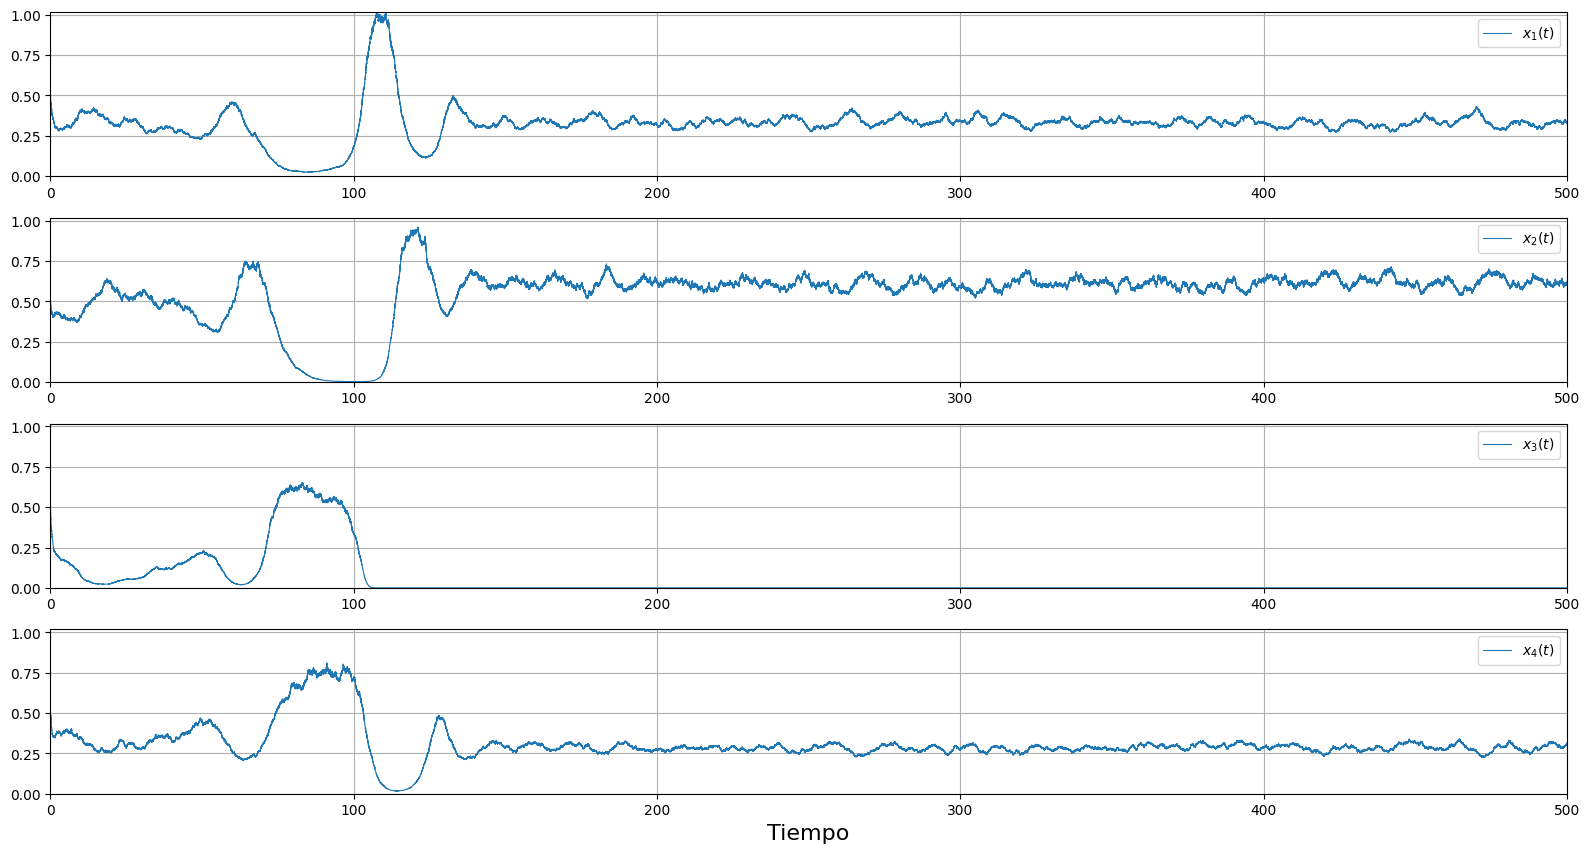

In [45]:
 # %matplotlib notebook

# creamos la gráfica
fig_em, ax_em = plt.subplots(4, 1, figsize=(16,9))

ax_em[0].plot(sim_t, sim_X[:,0], label=f'$x_1(t)$', lw =0.8)
ax_em[1].plot(sim_t, sim_X[:,1], label=f'$x_2(t)$', lw =0.8)
ax_em[2].plot(sim_t, sim_X[:,2], label=f'$x_3(t)$', lw =0.8)
ax_em[3].plot(sim_t, sim_X[:,3], label=f'$x_4(t)$', lw =0.8)

# ajustamos las etiquetas y el título
max_y = sim_X.max()
for i in range(4):
    ax_em[i].set_ylim([0, max_y])
    ax_em[i].set_xlim([t_span[0], t_span[1]])
    ax_em[i].legend()
    ax_em[i].grid(True)

ax_em[3].set_xlabel('Tiempo', fontsize=16)
# ax_em[1].set_xlim([0, 500])
plt.tight_layout(rect=[0, 0, 1, 0.96]) 


# mostramos la gráfica
plt.show()

In [ ]:
# fig_em.savefig('outputs/evol_temp_4especies_ruido1.png', dpi=600)

## 2.2. Representación del espacio de fases
También podemos hallar su espacio de fases como hicimos cuando estábamos en el caso determinista:

Forma de lineas: (1000000, 2, 3)
Forma de col: (1000001,)


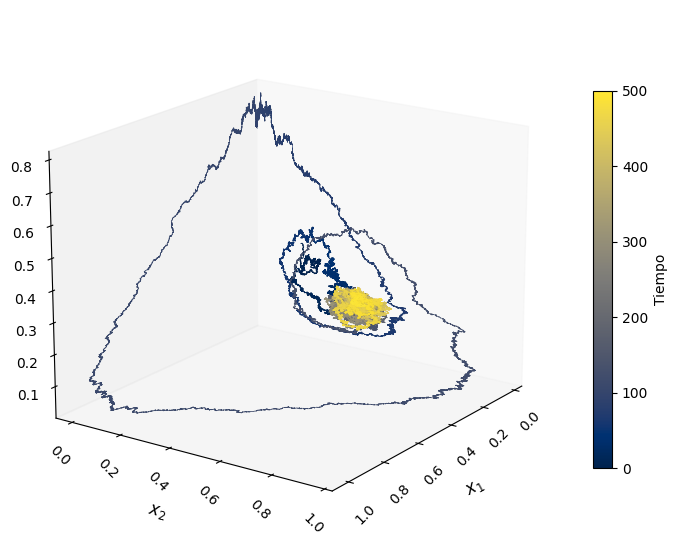

In [41]:
 # %matplotlib notebook


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# asignamos el color segun el tiempo
time_val = sim_t[:]
col = t_span[1] * (time_val - time_val.min()) / (time_val.max() - time_val.min())

# creamos las lineas
puntos = np.array([sim_X[:,0], sim_X[:,1], sim_X[:,3]]).T.reshape(-1, 1, 3)
lineas = np.concatenate([puntos[:-1], puntos[1:]], axis=1)
print("Forma de lineas:", lineas.shape)  # Debe ser (n_lines, 2, 3)
print("Forma de col:", col.shape)  


# coloreamos según col 
LC = Line3DCollection(lineas, cmap='cividis', norm = plt.Normalize(np.min(col), np.max(col)))
LC.set_array(col)
LC.set_linewidth(0.5)
ax.add_collection3d(LC)

# etiquetamos ejes y titulos
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)

# ponemos los ejes
xlim = [np.min(sim_X[:,0]), np.max(sim_X[:,0])]
ylim = [np.min(sim_X[:,1]), np.max(sim_X[:,1])]
zlim = [np.min(sim_X[:,3]), np.max(sim_X[:,3])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_zlim(zlim)

# ax.set_xticks([0.2, 0.4, 0.6, 0.8])
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
# ax.set_zticks([0.2, 0.4])

ax.tick_params(axis='x', labelsize=10, rotation=45)  
ax.tick_params(axis='y', labelsize=10, rotation=-45) 
ax.tick_params(axis='z', labelsize=10)  


# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(LC, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

plt.show()

# Guardamos la figura (opcional)
# fig.savefig('outputs/espacio_fasico_4especies_ruido1.png', dpi=600)




## 2.3. Cálculo de los exponentes de Lyapunov

Necesitamos un procedimiento diferente al aplicado en el caso determinista. Nos basamos en la aproximación usada en el paper de Wolf et al., donde se haya el mayor LCE reconstruyendo el atractor de una serie temporal.

In [ ]:
### BORRAR

def nearest_neighbour_4D(data_4d, idx, min_separation = 50):
    '''
    Busca el punto más cercano para el punto data_4d[idx],
    excluyendo los puntos que están muy próximos en el tiempo.
    
    :param data_4d: ndarray, shape (N,4)
    :param idx: int
        Índice del punto de referencia
    :param min_separation: int
        Número mínimo de índices (pasos de tiempo) para evitar vecinos de la misma órbita
    :return: nn_idx: int
        Índice del vecino más cercano
    :return dist_min: float
        Distancia mínima encontrada
    '''
    
    ref_point = data_4d[idx]
    
    # hallamos todas las distancias 
    dists = np.linalg.norm(data_4d - ref_point, axis = 1)
    # excluimos el propio punto
    dists[idx] = np.inf
    
    # excluimos puntos en un rango temporal muy cercano
    start_excl = max(0, idx - min_separation)
    end_excl = min(len(data_4d), idx + min_separation)
    dists[start_excl:end_excl] = np.inf
    
    nn_idx = np.argmin(dists)
    dist_min = dists[nn_idx]
    return nn_idx, dist_min


In [ ]:
### BORRAR

def nearest_neighbour_4D(data_4d, idx, min_separation = 50):
    '''
    Busca el punto más cercano para el punto data_4d[idx],
    excluyendo los puntos que están muy próximos en el tiempo.
    
    :param data_4d: ndarray, shape (N,4)
    :param idx: int
        Índice del punto de referencia
    :param min_separation: int
        Número mínimo de índices (pasos de tiempo) para evitar vecinos de la misma órbita
    :return: nn_idx: int
        Índice del vecino más cercano
    :return dist_min: float
        Distancia mínima encontrada
    '''
    
    ref_point = data_4d[idx]
    
    # hallamos todas las distancias 
    dists = np.linalg.norm(data_4d - ref_point, axis = 1)
    # excluimos el propio punto
    dists[idx] = np.inf
    
    # excluimos puntos en un rango temporal muy cercano
    start_excl = max(0, idx - min_separation)
    end_excl = min(len(data_4d), idx + min_separation)
    dists[start_excl:end_excl] = np.inf
    
    nn_idx = np.argmin(dists)
    dist_min = dists[nn_idx]
    return nn_idx, dist_min

def estimate_LCE1_Wolf(data_4d, evol_time, min_separation, dt, max_replacements, start_indices):
    '''
    
    Estimamos el mayor exponentes de Lyapunov usando el método 
    de Wolf  (en fixed time) para datos en R^4
    
    :param data_4d: ndarray, shape (N,4)
        Cada fila es un vector (x1, x2, x3, x4) en el instante de muestreo
    :param evol_time: int
        Número de pasos que se deja evolucionar cada par antes de renormalizar
    :param min_separation: int
        Número mínimo de pasos para excluir puntos muy próximos temporalmente
    :param df: float 
        Intervalo de muestreo
    :param max_replacements: int
        Número máximo de renormalizaciones a realizar
    :param start_indices: list
        Lista de índices iniciales a usar como puntos de referencia para promediar la estimación
        
    :return: lambda1: float
        Estimación del mayor LCE 
        
    :return: lambda_estimates: array
        Vector con la estimación de lamba1 en cada punto inicial
    '''
    
    N = len(data_4d)
        
    # almacenamos la estimación de cada punto
    lambda_estimates = [] 
    
    ## guardamos en una matriz todos los valores
    ## son nan para hacer la media mejor a que sean 0s
    all_vals = np.full(
        (len(start_indices), max_replacements), np.nan)
    
    for i, init_idx in enumerate(start_indices):
        idx_f = init_idx
        log_sum = 0.0
        count = 0
        
        # iteramos mientras se pueda evolucionar el punto de referencia y sin superar el máximo de iteraciones
        while (idx_f + evol_time < N) and (count < max_replacements):
            # buscamos vecino más cercano para el de referencia más cercano
            idx_n, dist_init = nearest_neighbour_4D(data_4d, idx_f, min_separation)
            
            # vemos que la distancia inicial es valida
            if np.isinf(dist_init) or dist_init < 1e-12:
                break
                
            # definimos los índices después de la evolución
            idx_f_next = idx_f + evol_time
            idx_n_next = idx_n + evol_time
            
            if idx_f_next >= N or idx_n_next >= N:
                break
            
            # calculamos la separación final
            dist_final = np.linalg.norm(data_4d[idx_f_next] - data_4d[idx_n_next])
            
            # acumulamos el logaritmo del crecimiento
            log_sum += np.log(dist_final / dist_init)
            count += 1
            
            ## valor parcial acumulado
            all_vals[i, count-1] = log_sum/(count*evol_time*dt)
            
            # renormalizamos
            idx_f = idx_f_next
        
        if count > 0:
            lambda_local = (log_sum / (count * evol_time * dt))
            
        else:
            lambda_local =np.nan
        
        # guardamos el valor a la lista       
        lambda_estimates.append(lambda_local)

    if len(lambda_estimates) > 0:
        # hacemos la media (quitando los nans)
        lambda1 = np.nanmean(lambda_estimates)

    else:
        lambda1 = 0
    
    return lambda1, lambda_estimates, all_vals

Voy a hallar el tiempo de decorrelación para usarlo como referencia en el evol_time

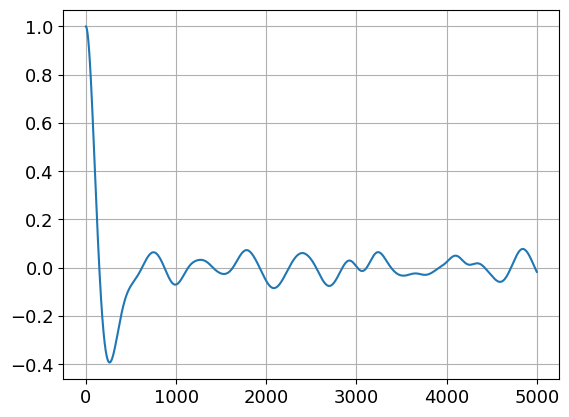

In [30]:
from statsmodels.tsa.stattools import acf

x1 = x_vals_EM_4esp[:,0]
x2 = x_vals_EM_4esp[:,1]
x3 = x_vals_EM_4esp[:,2]
x4 = x_vals_EM_4esp[:,3]
data_4d = np.array([x1, x2, x3, x4]).T

autocorr = acf(data_4d[:,0],nlags=5000)
plt.plot(autocorr)
plt.grid(True)
plt.show()

Debe ser superior al valor en el que corta con el eje horizontal. Tomaremos evol_time = 1500

In [ ]:

### BORRAR

# lo aplicamos a nuestro sistema de 4 especies
t = t_vals_EM_4esp  
dt = t[1] - t[0]
print('dt =', dt)

# definimos nuestro array de datos en R^4
x1 = x_vals_EM_4esp[:,0]
x2 = x_vals_EM_4esp[:,1]
x3 = x_vals_EM_4esp[:,2]
x4 = x_vals_EM_4esp[:,3]

data_4d = np.array([x1, x2, x3, x4]).T

# Parámetros para el algoritmo
evol_time = 500         # número de pasos para evolución entre renormalizaciones
min_sep = 180            # separación mínima en el tiempo para evitar vecinos triviales
max_rep = 500   #5000    # máximo número de renormalizaciones

# Podemos usar varios puntos de inicio para mejorar la estadística
start_indices = list(range(0, (len(data_4d)-evol_time), 100))

# tomo los valores intermedios
# in_i = int(len(data_4d)/5)
# in_f = int(len(data_4d) * 4/5)
# start_indices = list(range(in_i, in_f, 100))

dt = 0.05
Estimación del mayor exponente de Lyapunov: λ₁ ≈ 0.12510 [1/segundo]
len(lambda_array): 996


In [ ]:
### BORRAR

# estimamos lambda1
lambda1, lambda_array , _ = estimate_LCE1_Wolf(data_4d, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)

print(f"Estimación del mayor exponente de Lyapunov: λ₁ ≈ {lambda1:.5f} [1/segundo]")
print('len(lambda_array):', len(lambda_array))

In [4]:
# estimamos lambda1
evol_time = 500         # número de pasos para evolución entre renormalizaciones
min_sep = 180            # separación mínima en el tiempo para evitar vecinos triviales
max_rep = 500   #5000    # máximo número de renormalizaciones
start_indices = list(range(0, (len(sim_X)-evol_time), 100))

lambda1, lambda_array= model.estimate_LCE1_Wolf(
    evol_time=evol_time, min_separation=min_sep, max_replacements=max_rep, start_indices=start_indices)

print(f"Estimación del mayor exponente de Lyapunov: λ₁ ≈ {lambda1:.5f} [1/segundo]")
print('len(lambda_array):', len(lambda_array))

KeyboardInterrupt: 

Al final obtenemos un máx de ~30 renormalizaciones, y a medida que el punto es más elevado, menos renormalizaciones se pueden hacer. Además, su representación no queda demasiado bien. 

C:\Users\kikek\AppData\Local\Temp\ipykernel_23496\21452306.py:3: RuntimeWarning: Mean of empty slice
  val = np.nanmean(_[:,col])


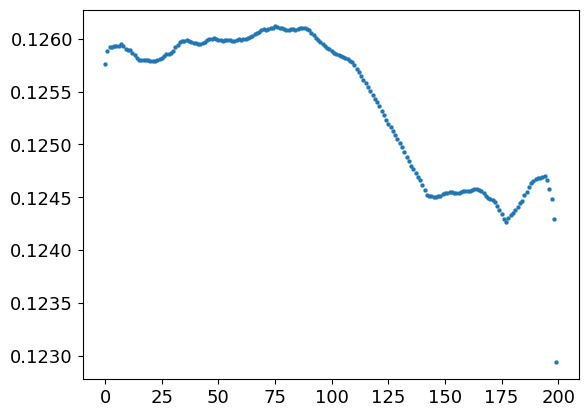

In [32]:
mean_vals = []
for col in range(_.shape[1]):
    val = np.nanmean(_[:,col])
    mean_vals.append(val)  

ind = range(len(mean_vals))

plt.scatter(ind, mean_vals, lw = 0.1, marker = '.')
plt.show()

In [33]:
# hallamos su desviación estandar
error_std = np.nanstd(lambda_array, ddof=1) 
media_lambda = np.nanmean(lambda_array)
print('Desviación estándar:', error_std)
print('Valor promedio:', media_lambda)

Desviación estándar: 0.008163419372240313
Valor promedio: 0.12509633080057309


<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kikek\AppData\Local\Temp\ipykernel_23496\713439447.py:10: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(start_indices, vect_media, 'r-', alpha = 1, label = f'Media $\hat\lambda_1 = $ {media_lambda:.3f}')
C:\Users\kikek\AppData\Local\Temp\ipykernel_23496\713439447.py:24: SyntaxWarning: invalid escape sequence '\s'
  label=f'Desv. Est. $\sigma_\lambda = $ {error_std:.3f}'


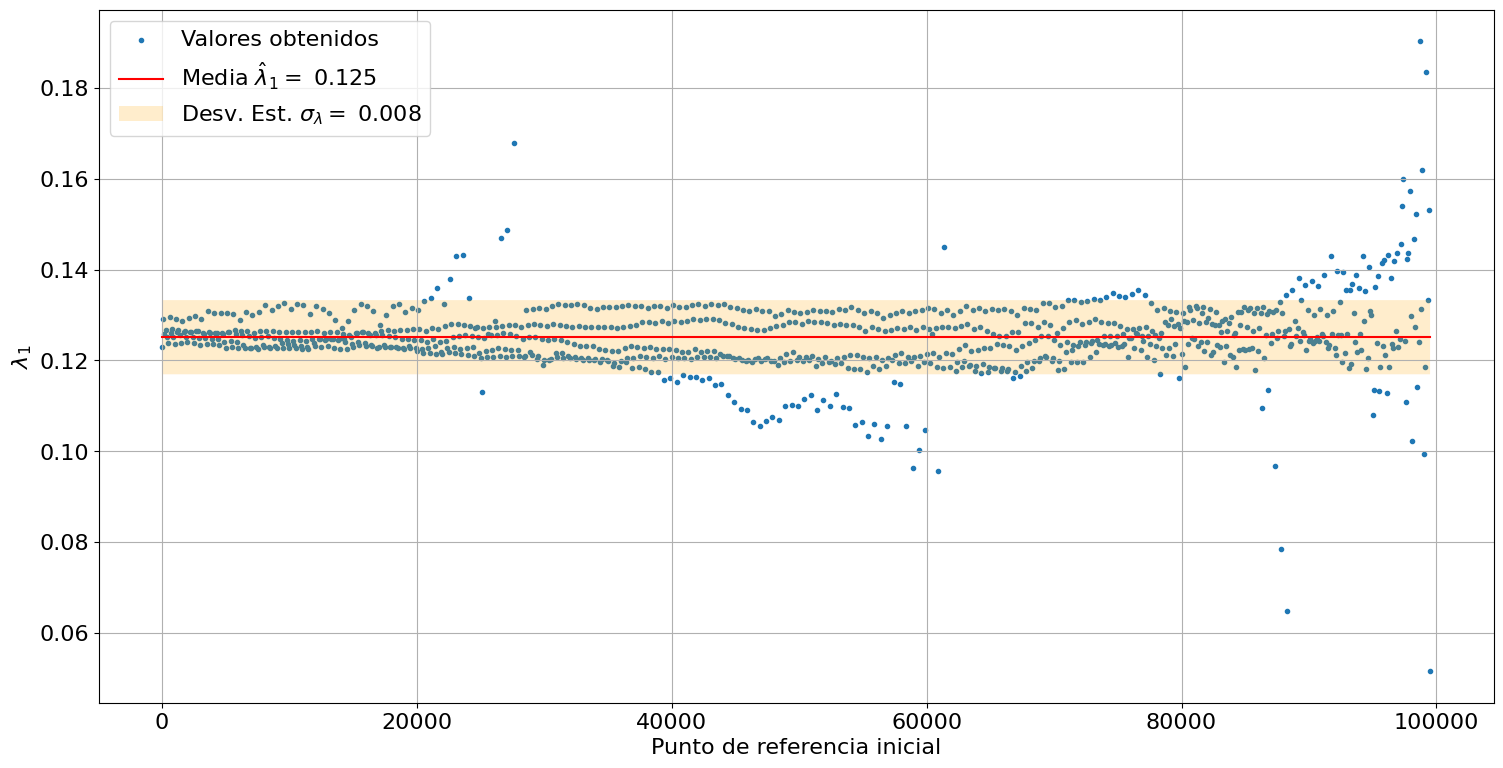

Mayor LCE 0.12510
Media LCE 0.008


In [34]:
# vemos su convergencia
fig_wolf_det, ax_wolf = plt.subplots(figsize = (18,9))

# graficamos los datos
# plt.plot(start_indices, lambda_array, alpha = 0.2) 
plt.scatter(start_indices, lambda_array, linewidths=1, marker = ".", label = 'Valores obtenidos')

# linea media
vect_media = media_lambda * np.ones_like(start_indices)
plt.plot(start_indices, vect_media, 'r-', alpha = 1, label = f'Media $\hat\lambda_1 = $ {media_lambda:.3f}')

# ponemos la banda de la desviación estándar
## límites superior e inferior 
y_min = vect_media - error_std
y_max = vect_media + error_std

## dibujamos la banda
plt.fill_between(
    start_indices, 
    y_min, 
    y_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {error_std:.3f}'
)

# dibujamos también el valor del LCE determinista
# media_D = .03032768
# vect_D = media_D* np.ones_like(start_indices)
# plt.plot(start_indices, vect_D, 'r--', alpha = 0.7, label = f'Sin ruido $\hat\lambda_1 = $ {media_D:.3f}')

# cambiamos los ejes un poco
ax_wolf.tick_params(axis='x', labelsize=16)
ax_wolf.tick_params(axis='y', labelsize=16)
plt.xlabel('Punto de referencia inicial', fontsize=16)
plt.ylabel(r'$\lambda_1$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.tight_layout()2
plt.show()
print(f"Mayor LCE {lambda1:.5f}")
print(f"Media LCE {error_std:.3f}") 

In [ ]:
# fig_wolf_det.savefig('outputs/wolf_lces.png', dpi=600, bbox_inches='tight')

### Gráfica de varias intensidades de ruido

In [35]:
# definimos los ruidos
sigma1 = np.array([0.025, 0.025, 0.025, 0.025]) # sin extinciones                                      
# sigma2 = np.array([.5, .2, .05, .2]) # aumenta autocorrelacion; se extinguen dos                     
# sigma3 = np.array([.01, .01, 1, 0.01]) # aumenta mucho la autocorrelación; se extingue uno       
sigma2 = np.array([0.03, 0.03, 0.03, 0.03])
sigma3 = np.array([0.01, 0.025, 0.04, 0.025])
sigma4 = 0.57 * np.array([0.8, 0.9, 1, 1.1])  # se extinguen 3, max LCE

# aplicamos EM a cada ruido
t_ruido1, x_ruido1 = euler_maruyama(system, x0, t_span, dt, r, a, sigma1)
t_ruido2, x_ruido2 = euler_maruyama(system, x0, t_span, dt, r, a, sigma2)
t_ruido3, x_ruido3 = euler_maruyama(system, x0, t_span, dt, r, a, sigma3)
t_ruido4, x_ruido4 = euler_maruyama(system, x0, t_span, dt, r, a, sigma4)
print('Calculadas las trayectoria ...')

lambda1_r1, lambda_array_r1 , _ = estimate_LCE1_Wolf(x_ruido1, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)
print('Calculados los LCEs del ruido 1 ...')

lambda1_r2, lambda_array_r2 , _ = estimate_LCE1_Wolf(x_ruido2, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)
print('Calculados los LCEs del ruido 2 ...')

lambda1_r3, lambda_array_r3 , _ = estimate_LCE1_Wolf(x_ruido3, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)
print('Calculados los LCEs del ruido 3 ...')

lambda1_r4, lambda_array_r4 , _ = estimate_LCE1_Wolf(x_ruido4, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)
print('Calculados los LCEs del ruido 4 ...')

# hallamos las medias de cada uno con su dispersión
std1 = np.nanstd(lambda_array_r1, ddof=1) 
media1 = np.nanmean(lambda_array_r1)

std2 = np.nanstd(lambda_array_r2, ddof=1) 
media2 = np.nanmean(lambda_array_r2)

std3 = np.nanstd(lambda_array_r3, ddof=1) 
media3 = np.nanmean(lambda_array_r3)

std4 = np.nanstd(lambda_array_r4, ddof=1) 
media4 = np.nanmean(lambda_array_r4)

print('Calculado valor medio y desviaciones')

Calculadas las trayectoria ...
Calculados los LCEs del ruido 1 ...
Calculados los LCEs del ruido 2 ...
Calculados los LCEs del ruido 3 ...
Calculado valor medio y desviaciones


In [37]:
print(media1, media2, media3, media4)

0.12657544509170626 0.12509633080057309 0.12644079031774913 0.4425372264803143


<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\h'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\h'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:80: SyntaxWarning: invalid escape sequence '\h'
<>:94: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\h'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\h'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:80: SyntaxWarning: invalid escape sequence '\h'
<>:94: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kikek\AppData\Local\Temp\ipykernel_29496\2962126224.py:10: SyntaxWarning: invalid escape sequence '\h'
  axs[0, 0].plot(start_indices, vect_media1, 'r--', alpha = 0.9, label =

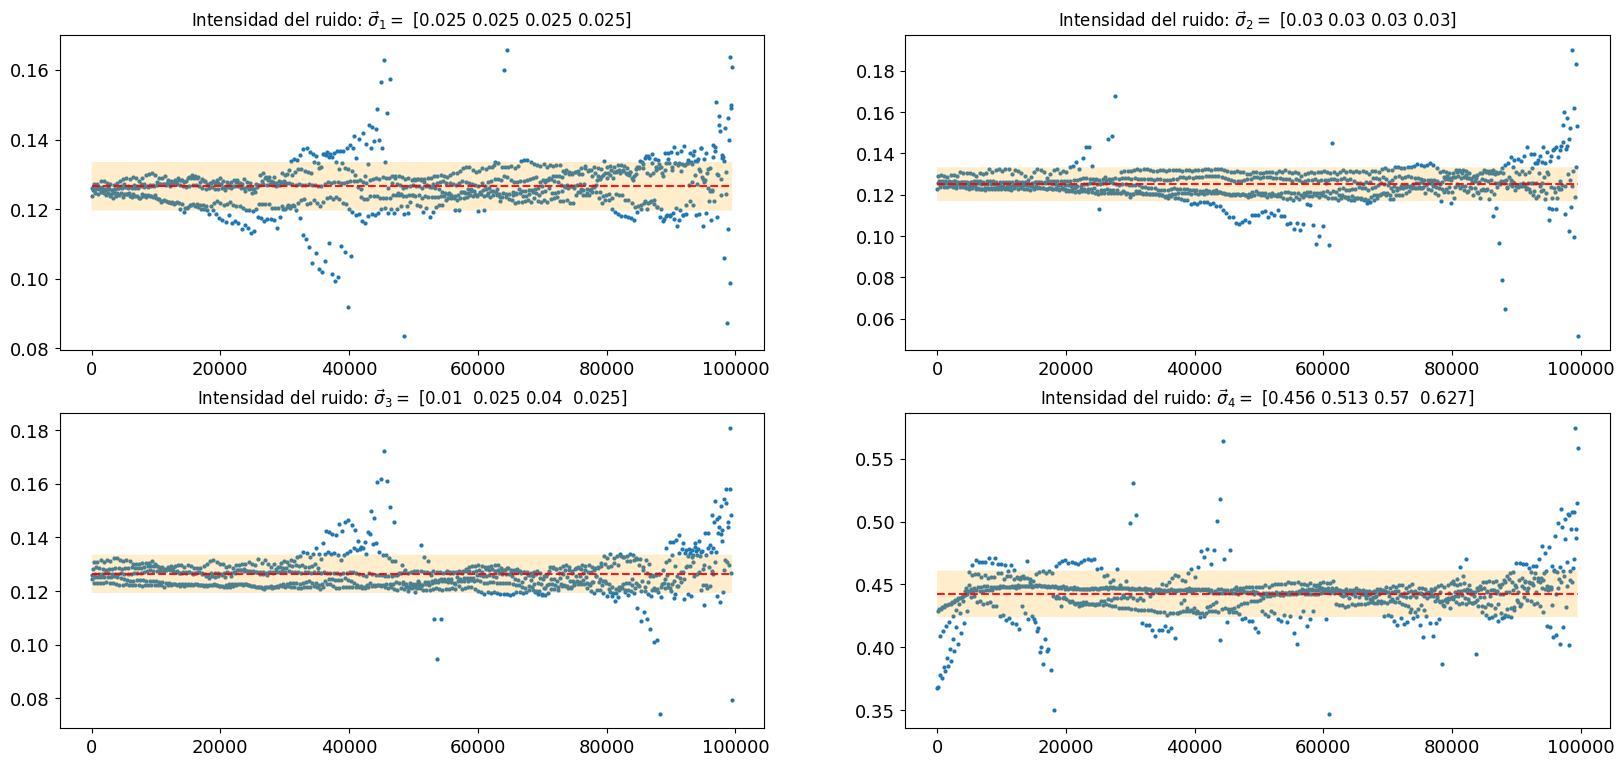

In [40]:
# hacemos una grafica comun
figs, axs = plt.subplots(2, 2, figsize = (20,9))

######## Primer ruido
axs[0, 0].scatter(start_indices, lambda_array_r1, linewidths=.01 ,marker = '.')
axs[0, 0].set_title(fr'Intensidad del ruido: $\vec\sigma_1 = $ {sigma1}')

# linea media
vect_media1 = media1 * np.ones_like(start_indices)
axs[0, 0].plot(start_indices, vect_media1, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media1:.3f}')

# ponemos la banda de la desviación estándar
## límites superior e inferior 
y1_min = vect_media1 - std1
y1_max = vect_media1 + std1

## dibujamos la banda
axs[0, 0].fill_between(
    start_indices, 
    y1_min, 
    y1_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {std1:.3f}'
)


######## Segundo ruido
axs[0, 1].scatter(start_indices, lambda_array_r2, linewidths=.01 ,marker = '.')
axs[0, 1].set_title(fr'Intensidad del ruido: $\vec\sigma_2 = $ {sigma2}')

# linea media
vect_media2 = media2 * np.ones_like(start_indices)
axs[0, 1].plot(start_indices, vect_media2, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media2:.3f}')

# ponemos la banda de la desviación estándar
## límites superior e inferior 
y2_min = vect_media2 - std2
y2_max = vect_media2 + std2

## dibujamos la banda
axs[0, 1].fill_between(
    start_indices, 
    y2_min, 
    y2_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {std2:.3f}'
)

######## Tercer ruido
axs[1, 0].scatter(start_indices, lambda_array_r3, linewidths=.01 ,marker = '.')
axs[1, 0].set_title(fr'Intensidad del ruido: $\vec\sigma_3 = $ {sigma3}')

# linea media
vect_media3 = media3 * np.ones_like(start_indices)
axs[1, 0].plot(start_indices, vect_media3, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media3:.3f}')

# ponemos la banda de la desviación estándar
## límites superior e inferior 
y3_min = vect_media3 - std3
y3_max = vect_media3 + std3

## dibujamos la banda
axs[1, 0].fill_between(
    start_indices, 
    y3_min, 
    y3_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {std3:.3f}'
)

######## Cuarto ruido
axs[1, 1].scatter(start_indices, lambda_array_r4, linewidths=.01 ,marker = '.')
axs[1, 1].set_title(fr'Intensidad del ruido: $\vec\sigma_4 = $ {sigma4}')

# linea media
vect_media4 = media4 * np.ones_like(start_indices)
axs[1, 1].plot(start_indices, vect_media4, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media4:.3f}')

# ponemos la banda de la desviación estándar
## límites superior e inferior 
y4_min = vect_media4 - std4
y4_max = vect_media4 + std4

## dibujamos la banda
axs[1, 1].fill_between(
    start_indices, 
    y4_min, 
    y4_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {std4:.3f}'
)

In [41]:
# figs.savefig('outputs/lces_ruido_comunes', dpi=600) 

### Barrido de ruidos para hallar extremos de LCEs
NO EJECUTAR. Tarda más de 30h en total este apartado. Se pueden cargar los datos al final de la sección.

In [41]:
# array_sigmas = np.arange(start=0.0, stop=5.0, step=.01)
array_sigmas = np.linspace(start = 0.0, stop = 1.5, num = 500)
Nit = len(array_sigmas)
print('Número de iteraciones: ', Nit)

# creamos variables
it = 0
array_LCEs = np.empty((3, Nit))

array_LCEs[0,:] = array_sigmas

for idx, sigma in enumerate(array_sigmas):
    print(round(it/Nit * 100,3), '%', end='...')
    
    # creamos el vector de ruido
    vect_ruido = sigma * np.array([0.8, 0.9, 1, 1.1]) # distribución asimétrical de ruido
    
    # resolvemos el sistema con Euler-Maruyama
    t, x = euler_maruyama(system, x0, t_span, dt, r, a, vect_ruido)

    # hallamos los LCEs con el método de Wolf
    lambda1, vect_lambdas , _ = estimate_LCE1_Wolf(x, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)

    # hallamos la media y std
    std = np.nanstd(vect_lambdas, ddof=1) 
    media = np.nanmean(vect_lambdas)
    
    # guardamos los valores
    array_LCEs[1,idx] = media
    array_LCEs[2,idx] = std

    it += 1


Número de iteraciones:  500
0.0 %...0.2 %...0.4 %...0.6 %...0.8 %...1.0 %...1.2 %...1.4 %...1.6 %...1.8 %...2.0 %...2.2 %...2.4 %...2.6 %...2.8 %...3.0 %...3.2 %...3.4 %...3.6 %...3.8 %...4.0 %...4.2 %...4.4 %...4.6 %...4.8 %...5.0 %...5.2 %...5.4 %...5.6 %...5.8 %...6.0 %...6.2 %...6.4 %...6.6 %...6.8 %...7.0 %...7.2 %...7.4 %...7.6 %...7.8 %...8.0 %...8.2 %...8.4 %...8.6 %...8.8 %...9.0 %...9.2 %...9.4 %...9.6 %...9.8 %...10.0 %...10.2 %...10.4 %...10.6 %...10.8 %...11.0 %...11.2 %...11.4 %...11.6 %...11.8 %...12.0 %...12.2 %...12.4 %...12.6 %...12.8 %...13.0 %...13.2 %...13.4 %...13.6 %...13.8 %...14.0 %...14.2 %...14.4 %...14.6 %...14.8 %...15.0 %...15.2 %...15.4 %...15.6 %...15.8 %...16.0 %...16.2 %...16.4 %...16.6 %...16.8 %...17.0 %...17.2 %...17.4 %...17.6 %...17.8 %...18.0 %...18.2 %...18.4 %...18.6 %...18.8 %...19.0 %...19.2 %...19.4 %...19.6 %...19.8 %...20.0 %...20.2 %...20.4 %...20.6 %...20.8 %...21.0 %...21.2 %...21.4 %...21.6 %...21.8 %...22.0 %...22.2 %...22.4 %...22.6 

C:\Users\kikek\AppData\Local\Temp\ipykernel_29496\3941974798.py:62: RuntimeWarning: divide by zero encountered in log
  log_sum += np.log(dist_final / dist_init)
C:\Users\kikek\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


71.4 %...71.6 %...71.8 %...72.0 %...72.2 %...72.4 %...72.6 %...72.8 %...73.0 %...73.2 %...73.4 %...73.6 %...73.8 %...74.0 %...74.2 %...74.4 %...74.6 %...74.8 %...75.0 %...75.2 %...75.4 %...75.6 %...75.8 %...76.0 %...76.2 %...76.4 %...76.6 %...76.8 %...77.0 %...77.2 %...77.4 %...77.6 %...77.8 %...78.0 %...78.2 %...78.4 %...78.6 %...78.8 %...79.0 %...79.2 %...79.4 %...79.6 %...79.8 %...80.0 %...80.2 %...80.4 %...80.6 %...80.8 %...81.0 %...81.2 %...81.4 %...81.6 %...81.8 %...82.0 %...82.2 %...82.4 %...82.6 %...82.8 %...83.0 %...83.2 %...83.4 %...83.6 %...83.8 %...84.0 %...84.2 %...84.4 %...84.6 %...84.8 %...85.0 %...85.2 %...85.4 %...85.6 %...85.8 %...86.0 %...86.2 %...86.4 %...86.6 %...86.8 %...87.0 %...87.2 %...87.4 %...87.6 %...87.8 %...88.0 %...88.2 %...88.4 %...88.6 %...88.8 %...89.0 %...89.2 %...89.4 %...89.6 %...89.8 %...90.0 %...90.2 %...90.4 %...90.6 %...90.8 %...91.0 %...91.2 %...91.4 %...91.6 %...91.8 %...92.0 %...92.2 %...92.4 %...92.6 %...92.8 %...93.0 %...93.2 %...93.4 %...9

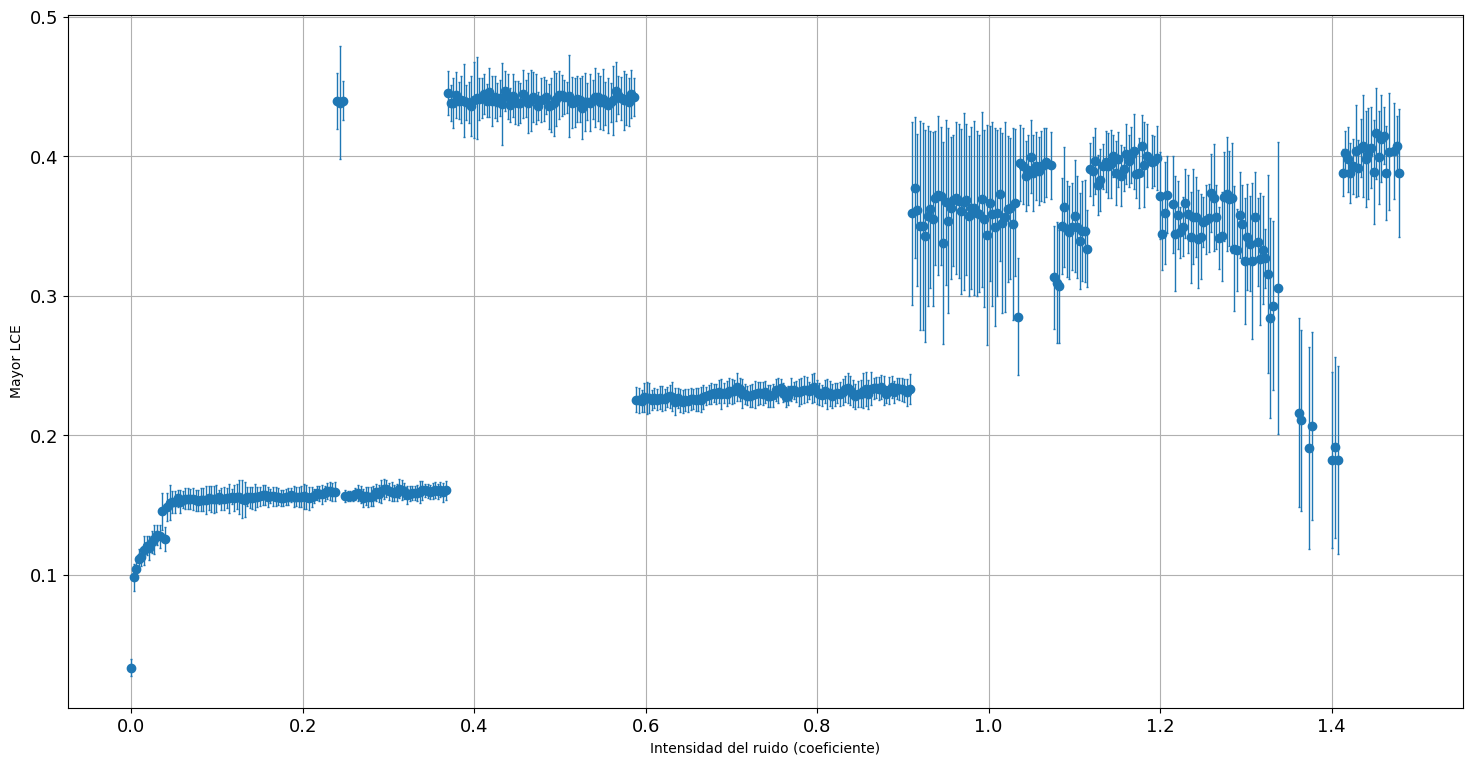

[[0.         0.00300601 0.00601202 ... 1.49398798 1.49699399 1.5       ]
 [0.03351668 0.09837683 0.10414201 ...       -inf       -inf       -inf]
 [0.00600906 0.00951095 0.00777143 ...        nan        nan        nan]]


In [47]:
# creamos una gráfica para verlo
fig_barridos, ax_barridos = plt.subplots(figsize = (18,9))
plt.errorbar(
    x = array_LCEs[0, :], y = array_LCEs[1, :], yerr = array_LCEs[2, :], fmt = 'o', elinewidth = 1, capsize = 1 
)

plt.xlabel('Intensidad del ruido (coeficiente)')
plt.ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()
print(array_LCEs)

In [44]:
# ahora con una distribución homogénea de la intensidad del ruido
array_sigmas = np.linspace(start = 0.0, stop = 1.5, num = 500)
Nit = len(array_sigmas)
print('Número de iteraciones: ', Nit)

# creamos variables
it = 0
array_LCEs_2 = np.empty((3, Nit))

array_LCEs_2[0,:] = array_sigmas

for idx, sigma in enumerate(array_sigmas):
    print(round(it/Nit * 100,3), '%', end='...')
    
    # creamos el vector de ruido
    vect_ruido = sigma * np.array([1, 1, 1, 1]) # distribución simetrica de ruido
    
    # resolvemos el sistema con Euler-Maruyama
    t, x = euler_maruyama(system, x0, t_span, dt, r, a, vect_ruido)

    # hallamos los LCEs con el método de Wolf
    lambda1, vect_lambdas , _ = estimate_LCE1_Wolf(x, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)

    # hallamos la media y std
    std = np.nanstd(vect_lambdas, ddof=1)  
    media = np.nanmean(vect_lambdas)
    
    # guardamos los valores
    array_LCEs_2[1,idx] = media
    array_LCEs_2[2,idx] = std

    it += 1


Número de iteraciones:  500
0.0 %...0.2 %...0.4 %...0.6 %...0.8 %...1.0 %...1.2 %...1.4 %...1.6 %...1.8 %...2.0 %...2.2 %...2.4 %...2.6 %...2.8 %...3.0 %...3.2 %...3.4 %...3.6 %...3.8 %...4.0 %...4.2 %...4.4 %...4.6 %...4.8 %...5.0 %...5.2 %...5.4 %...5.6 %...5.8 %...6.0 %...6.2 %...6.4 %...6.6 %...6.8 %...7.0 %...7.2 %...7.4 %...7.6 %...7.8 %...8.0 %...8.2 %...8.4 %...8.6 %...8.8 %...9.0 %...9.2 %...9.4 %...9.6 %...9.8 %...10.0 %...10.2 %...10.4 %...10.6 %...10.8 %...11.0 %...11.2 %...11.4 %...11.6 %...11.8 %...12.0 %...12.2 %...12.4 %...12.6 %...12.8 %...13.0 %...13.2 %...13.4 %...13.6 %...13.8 %...14.0 %...14.2 %...14.4 %...14.6 %...14.8 %...15.0 %...15.2 %...15.4 %...15.6 %...15.8 %...16.0 %...16.2 %...16.4 %...16.6 %...16.8 %...17.0 %...17.2 %...17.4 %...17.6 %...17.8 %...18.0 %...18.2 %...18.4 %...18.6 %...18.8 %...19.0 %...19.2 %...19.4 %...19.6 %...19.8 %...20.0 %...20.2 %...20.4 %...20.6 %...20.8 %...21.0 %...21.2 %...21.4 %...21.6 %...21.8 %...22.0 %...22.2 %...22.4 %...22.6 

C:\Users\kikek\AppData\Local\Temp\ipykernel_29496\3941974798.py:62: RuntimeWarning: divide by zero encountered in log
  log_sum += np.log(dist_final / dist_init)
C:\Users\kikek\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


79.2 %...79.4 %...79.6 %...79.8 %...80.0 %...80.2 %...80.4 %...80.6 %...80.8 %...81.0 %...81.2 %...81.4 %...81.6 %...81.8 %...82.0 %...82.2 %...82.4 %...82.6 %...82.8 %...83.0 %...83.2 %...83.4 %...83.6 %...83.8 %...84.0 %...84.2 %...84.4 %...84.6 %...84.8 %...85.0 %...85.2 %...85.4 %...85.6 %...85.8 %...86.0 %...86.2 %...86.4 %...86.6 %...86.8 %...87.0 %...87.2 %...87.4 %...87.6 %...87.8 %...88.0 %...88.2 %...88.4 %...88.6 %...88.8 %...89.0 %...89.2 %...89.4 %...89.6 %...89.8 %...90.0 %...90.2 %...90.4 %...90.6 %...90.8 %...91.0 %...91.2 %...91.4 %...91.6 %...91.8 %...92.0 %...92.2 %...92.4 %...92.6 %...92.8 %...93.0 %...93.2 %...93.4 %...93.6 %...93.8 %...94.0 %...94.2 %...94.4 %...94.6 %...94.8 %...95.0 %...95.2 %...95.4 %...95.6 %...95.8 %...96.0 %...96.2 %...96.4 %...96.6 %...96.8 %...97.0 %...97.2 %...97.4 %...97.6 %...97.8 %...98.0 %...98.2 %...98.4 %...98.6 %...98.8 %...99.0 %...99.2 %...99.4 %...99.6 %...99.8 %...

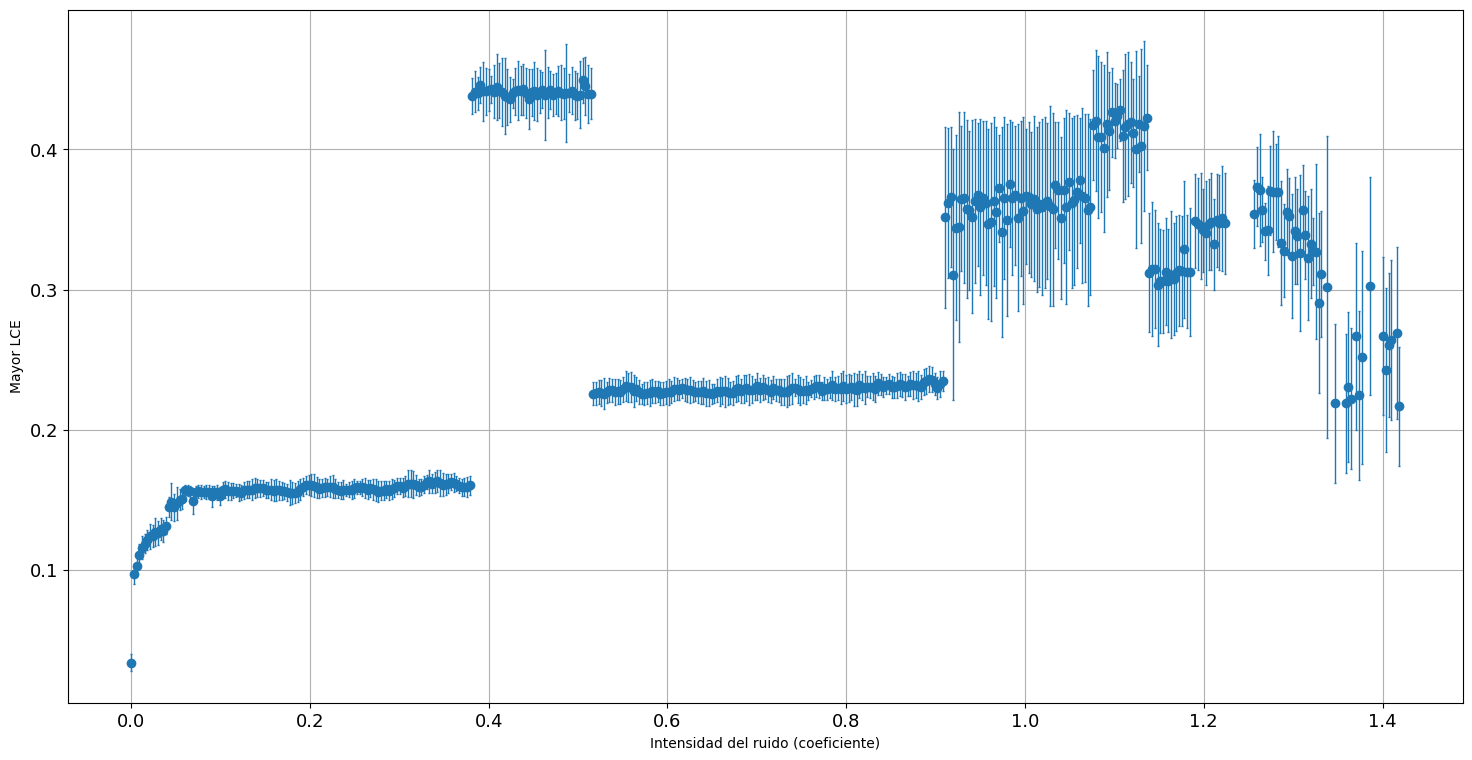

[[0.         0.00300601 0.00601202 ... 1.49398798 1.49699399 1.5       ]
 [0.03351668 0.09837683 0.10414201 ...       -inf       -inf       -inf]
 [0.00600906 0.00951095 0.00777143 ...        nan        nan        nan]]


In [51]:
# creamos una gráfica para verlo
fig_barridos2, ax_barridos2 = plt.subplots(figsize = (18,9))
# plt.scatter(array_LCEs_2[0, :], array_LCEs_2[1, :], linewidth = 1, marker = '.')
plt.errorbar(
    x = array_LCEs_2[0, :], y = array_LCEs_2[1, :], yerr = array_LCEs_2[2, :], fmt = 'o', elinewidth = 1, capsize = 1 
)

plt.xlabel('Intensidad del ruido (coeficiente)')
plt.ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()
print(array_LCEs)

Para guardar/cargar los datos:

In [50]:
# guardamos ambos arrays porque son muy largos de computar
# np.save('data/barrido_asim.npy', array_LCEs)
# np.save('data/barrido_sim.npy', array_LCEs_2)


In [120]:
array_LCEs = np.load('data/barrido_asim.npy')

### Barrido para hallar umbrales de extinción
Como aquí no buscamos LCEs, tarda menos. La última vez fueron ~15min

In [54]:
array_extinciones = np.empty((2, Nit))
array_extinciones[0,:] = array_sigmas
idx_check = int(0.9 * 1e5)  # percentil 90 de los indices, 

for idx, sigma in enumerate(array_sigmas):
    # guardamos en cada iteracion las extinciones
    nex = 0
    
    # creamos el vector de ruido
    vs = sigma * np.array([0.8, 0.9, 1, 1.1]) # asimetrico
    
    # resolvemos con Euler-Maruyama
    t, x = euler_maruyama(system, x0, t_span, dt, r, a, vs)

    # obtenemos la fila concreta
    row_ext = x[idx_check, :]
    
    # contamos los ceros
    nex = (row_ext == 0).sum()
    
    # lo guardamos
    array_extinciones[1,idx] = nex
        

[[0.00000000e+00 3.00601202e-03 6.01202405e-03 9.01803607e-03
  1.20240481e-02 1.50300601e-02 1.80360721e-02 2.10420842e-02
  2.40480962e-02 2.70541082e-02 3.00601202e-02 3.30661323e-02
  3.60721443e-02 3.90781563e-02 4.20841683e-02 4.50901804e-02
  4.80961924e-02 5.11022044e-02 5.41082164e-02 5.71142285e-02
  6.01202405e-02 6.31262525e-02 6.61322645e-02 6.91382766e-02
  7.21442886e-02 7.51503006e-02 7.81563126e-02 8.11623246e-02
  8.41683367e-02 8.71743487e-02 9.01803607e-02 9.31863727e-02
  9.61923848e-02 9.91983968e-02 1.02204409e-01 1.05210421e-01
  1.08216433e-01 1.11222445e-01 1.14228457e-01 1.17234469e-01
  1.20240481e-01 1.23246493e-01 1.26252505e-01 1.29258517e-01
  1.32264529e-01 1.35270541e-01 1.38276553e-01 1.41282565e-01
  1.44288577e-01 1.47294589e-01 1.50300601e-01 1.53306613e-01
  1.56312625e-01 1.59318637e-01 1.62324649e-01 1.65330661e-01
  1.68336673e-01 1.71342685e-01 1.74348697e-01 1.77354709e-01
  1.80360721e-01 1.83366733e-01 1.86372745e-01 1.89378758e-01
  1.9238

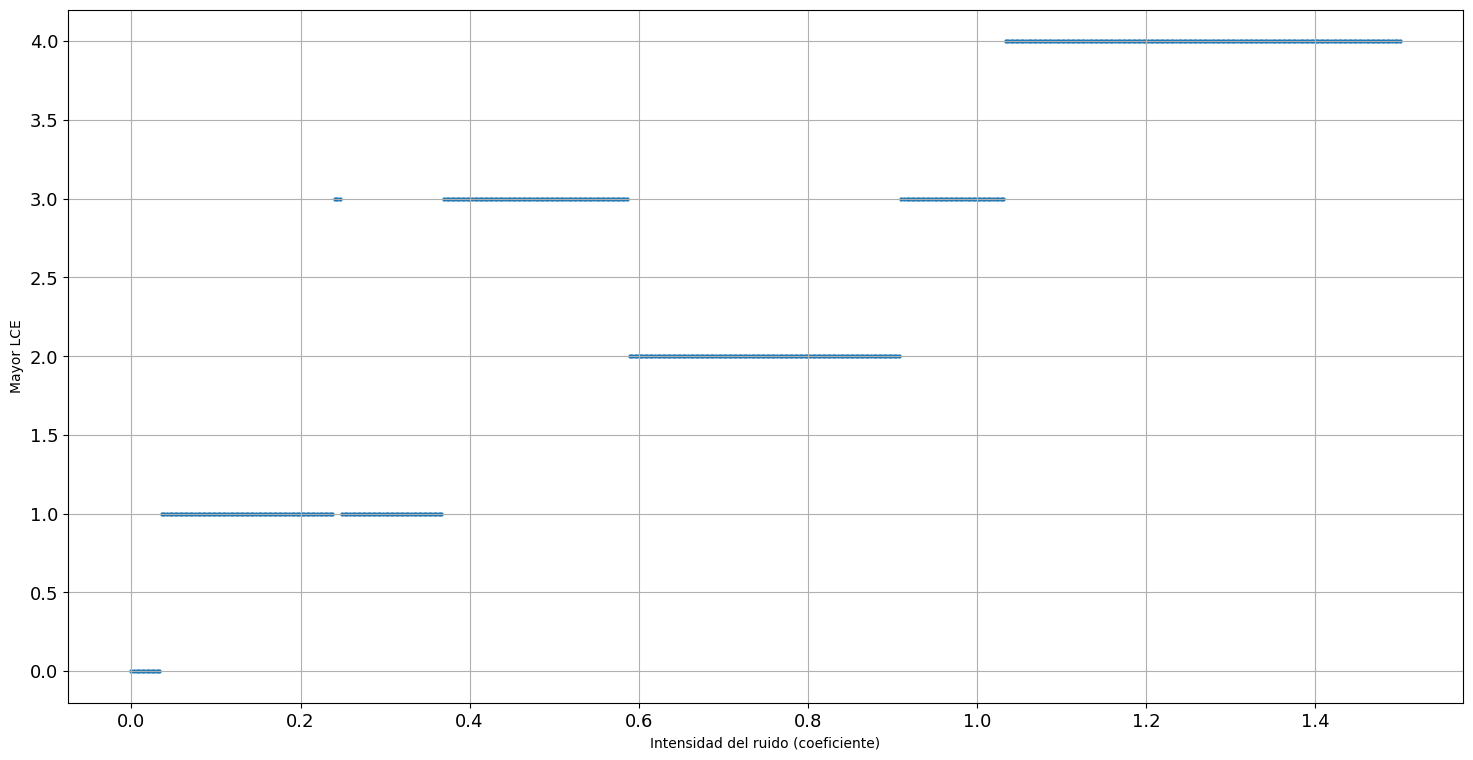

[[0.         0.00300601 0.00601202 ... 1.49398798 1.49699399 1.5       ]
 [0.03351668 0.09837683 0.10414201 ...       -inf       -inf       -inf]
 [0.00600906 0.00951095 0.00777143 ...        nan        nan        nan]]


In [55]:
fig_ext, ax_ext = plt.subplots(figsize = (18,9))
ax_ext.scatter(
    x = array_extinciones[0, :], y = array_extinciones[1, :], lw =0.1, marker = '.'
)

ax_ext.set_xlabel('Intensidad del ruido (coeficiente)')
ax_ext.set_ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()
print(array_LCEs)

### Gráfica comparativa
Para ver similitudes entre exponentes de Lyapunov y extinciones

In [102]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [124]:
# solo quiero los que tienen una intensidad de ruido menor que 1.2 (el resto no son significativos)
umbral_1 = array_LCEs[0,:] <= 1.2
array_LCEs_filt = array_LCEs[:,umbral_1]

umbral_2 = array_extinciones[0, :] <= 1.2
array_extinciones_filt = array_extinciones[:,umbral_2]

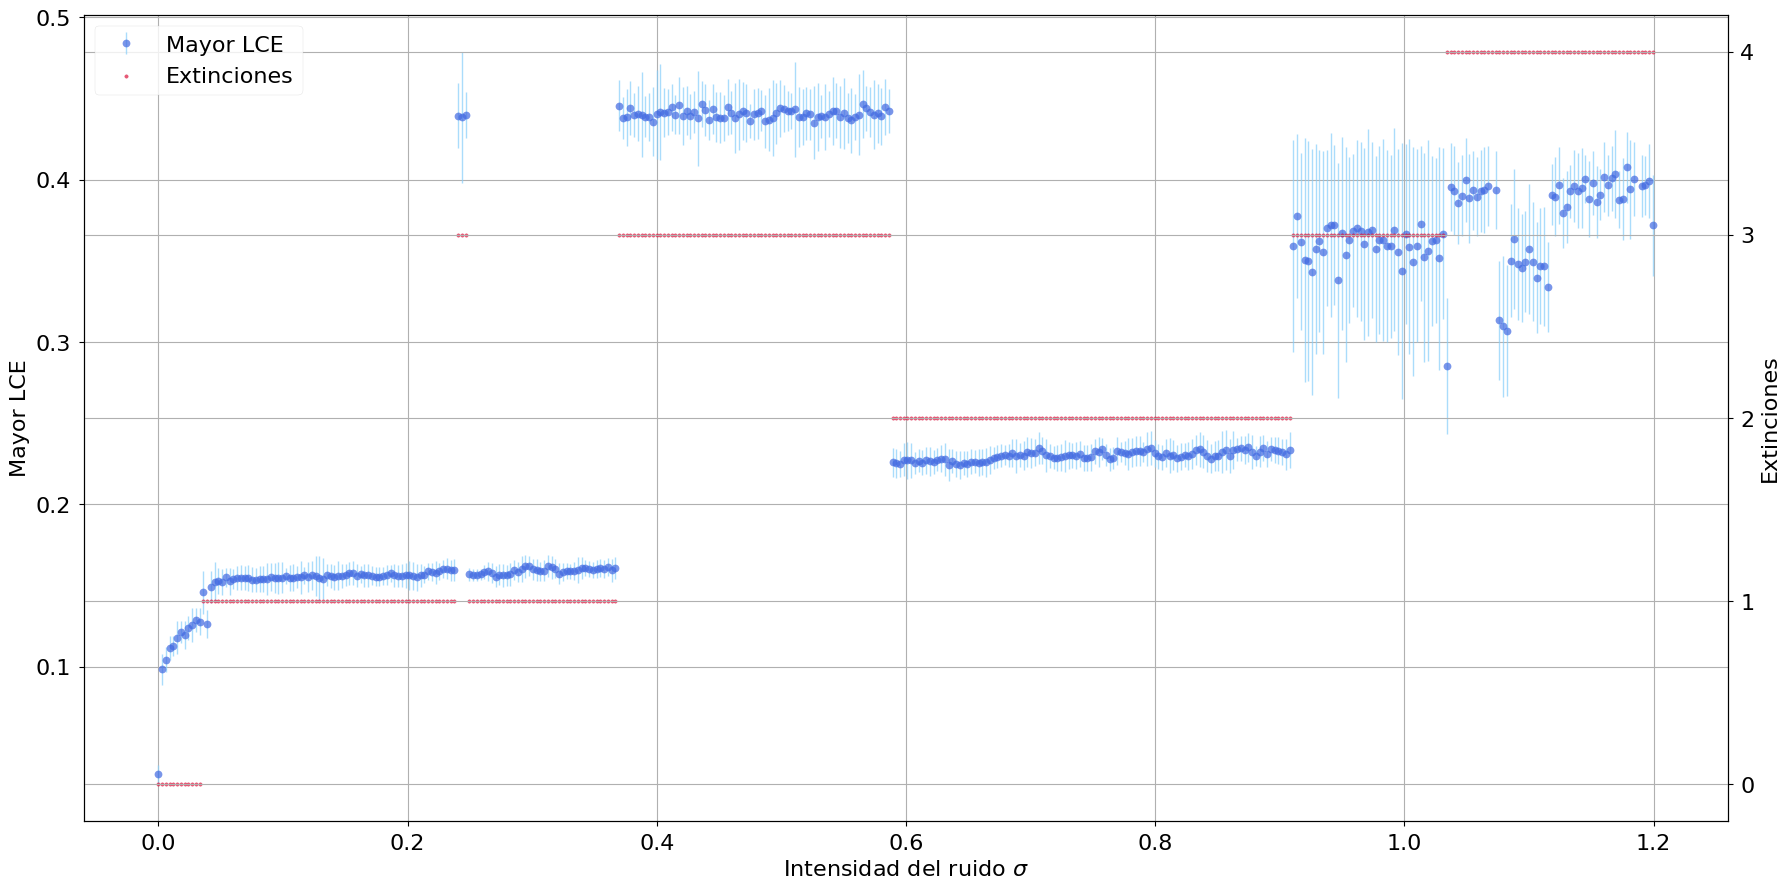

In [132]:
 # cambiamos el estilo
plt.style.use('seaborn-v0_8-paper')
# plt.style.use('default')

fig_doble, ax_doble = plt.subplots(figsize=(18, 9))

# primer eje
lce_plot = ax_doble.errorbar(
    x=array_LCEs_filt[0, :],
    y=array_LCEs_filt[1, :],
    yerr=array_LCEs_filt[2, :],
    fmt='o',
    color='royalblue',      
    ecolor='lightskyblue',   
    elinewidth=1,
    capsize=1,
    alpha=0.7,              
    label='Mayor LCE'
)

ax_doble.set_xlabel(r'Intensidad del ruido $\sigma$', fontsize=16)
ax_doble.set_ylabel('Mayor LCE', color='k', fontsize=16)
ax_doble.tick_params(axis='x', labelsize=16)
ax_doble.tick_params(axis='y', labelsize=16, colors='k')
ax_doble.grid()

# segundo eje
ax_2 = ax_doble.twinx()
ext_plot = ax_2.scatter(
    x=array_extinciones_filt[0, :],
    y=array_extinciones_filt[1, :],
    color='crimson',
    alpha=0.7,
    label='Extinciones',
    s=25,
    marker='.'
)

ax_2.set_ylabel('Extinciones', color='k', fontsize=16)
ax_2.tick_params(axis='y', labelsize=16, colors='k')
ax_2.set_yticks(range(0, 5))
ax_2.grid()


# combinamos las leyendas
lines1, labels1 = ax_doble.get_legend_handles_labels()
lines2, labels2 = ax_2.get_legend_handles_labels()
ax_2.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=16)

plt.tight_layout()
plt.show()

In [133]:
fig_doble.savefig('outputs/doble_asim.png', dpi = 600, bbox_inches = 'tight')


## 2.4 Cálculo de la matriz de correlación
Podemos usar la función definida para el caso determinista

In [161]:
R_matrix_est= np.ones((4,4))

for i in range(4):
    for j in range(4):
        R_matrix_est[i,j] = ccr(x_vals_EM_4esp[:,i], x_vals_EM_4esp[:,j])

print('MATRIZ DE CORRELACIÓN')
print(R_matrix_est)

MATRIZ DE CORRELACIÓN
[[ 1.         -0.09075608 -0.45071623 -0.43949695]
 [-0.09075608  1.          0.17062219  0.09638586]
 [-0.45071623  0.17062219  1.          0.67679054]
 [-0.43949695  0.09638586  0.67679054  1.        ]]


## 2.5 Cálculo de la Correlación Total
Aplicamos las funciones que hemos definido antes

In [162]:
# hallamos la entropía de cada serie
H1_est = entropy(x_vals_EM_4esp[:,0])
H2_est = entropy(x_vals_EM_4esp[:,1])
H3_est = entropy(x_vals_EM_4esp[:,2])
H4_est = entropy(x_vals_EM_4esp[:,3])

print(H1_est , H2_est , H3_est , H4_est )

bins =  12
bins =  12
bins =  12
bins =  12
1.7937581793696837 0.019710479095914914 0.23892445410506377 0.2399788250992289


In [163]:
# la calculamos
H_joint_est = joint_entropy(x_vals_EM_4esp[:,0] , x_vals_EM_4esp[:,1] , x_vals_EM_4esp[:,2] , x_vals_EM_4esp[:,3] )
print(H_joint_est)

1.0120697904164182


In [164]:
# hallamos la correlación total
TC_est = np.sum([H1_est, H2_est, H3_est, H4_est]) - H_joint_est

print('TC = ',TC_est)

TC =  1.280302147253473


---
# 3. Comparaciones

## 3.1 Comparación de la evolución temporal
Voy a ver la diferencia de la resolución de nuestro sistema mediante solve_ivp() y el método de Euler-Maruyama

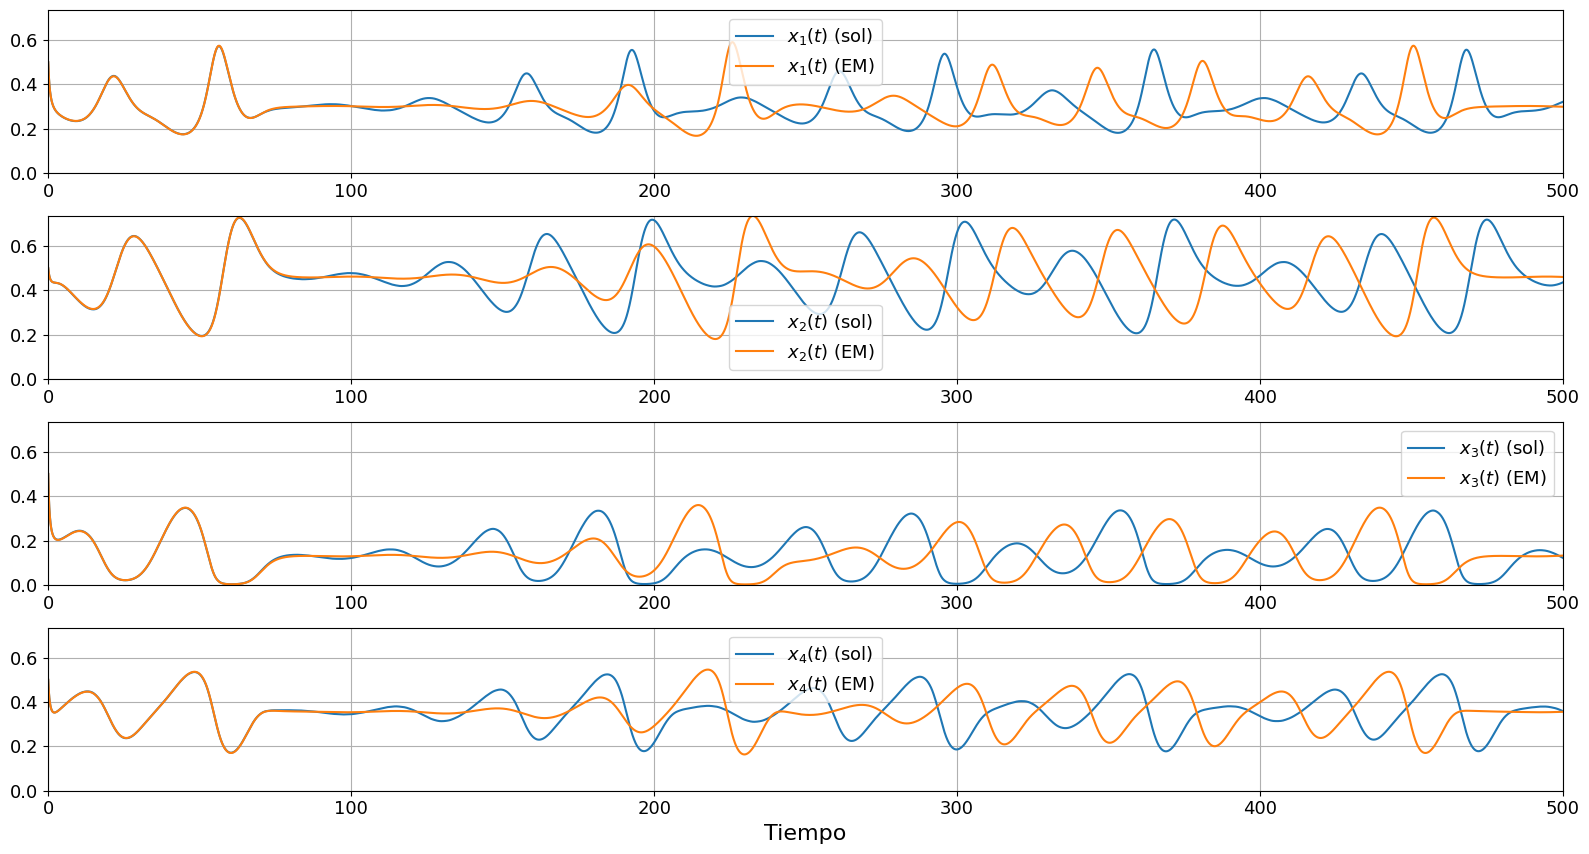

In [90]:
fig, ax = plt.subplots(4, 1, figsize=(16, 9))

# Graficamos la solución "sol"
ax[0].plot(sol.t, sol.y[0], label='$x_1(t)$ (sol)')
ax[1].plot(sol.t, sol.y[1], label='$x_2(t)$ (sol)')
ax[2].plot(sol.t, sol.y[2], label='$x_3(t)$ (sol)')
ax[3].plot(sol.t, sol.y[3], label='$x_4(t)$ (sol)')

# Graficamos la solución "EM"
ax[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 0], label='$x_1(t)$ (EM)')
ax[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 1], label='$x_2(t)$ (EM)')
ax[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 2], label='$x_3(t)$ (EM)')
ax[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 3], label='$x_4(t)$ (EM)')

# Ajustes generales para cada subplot
max_y = max(sol.y.max(), x_vals_EM_4esp.max())
for i in range(4):
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].grid(True)
    ax[i].legend(fontsize=13)  # Aseguramos que la leyenda distinga ambas series

ax[3].set_xlabel('Tiempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\_'
<>:24: SyntaxWarning: invalid escape sequence '\_'
C:\Users\kikek\AppData\Local\Temp\ipykernel_23496\2842938460.py:24: SyntaxWarning: invalid escape sequence '\_'
  line_solv = mlines.Line2D([], [], color='C0', label=f'Valores de $solve\_ivp()$')


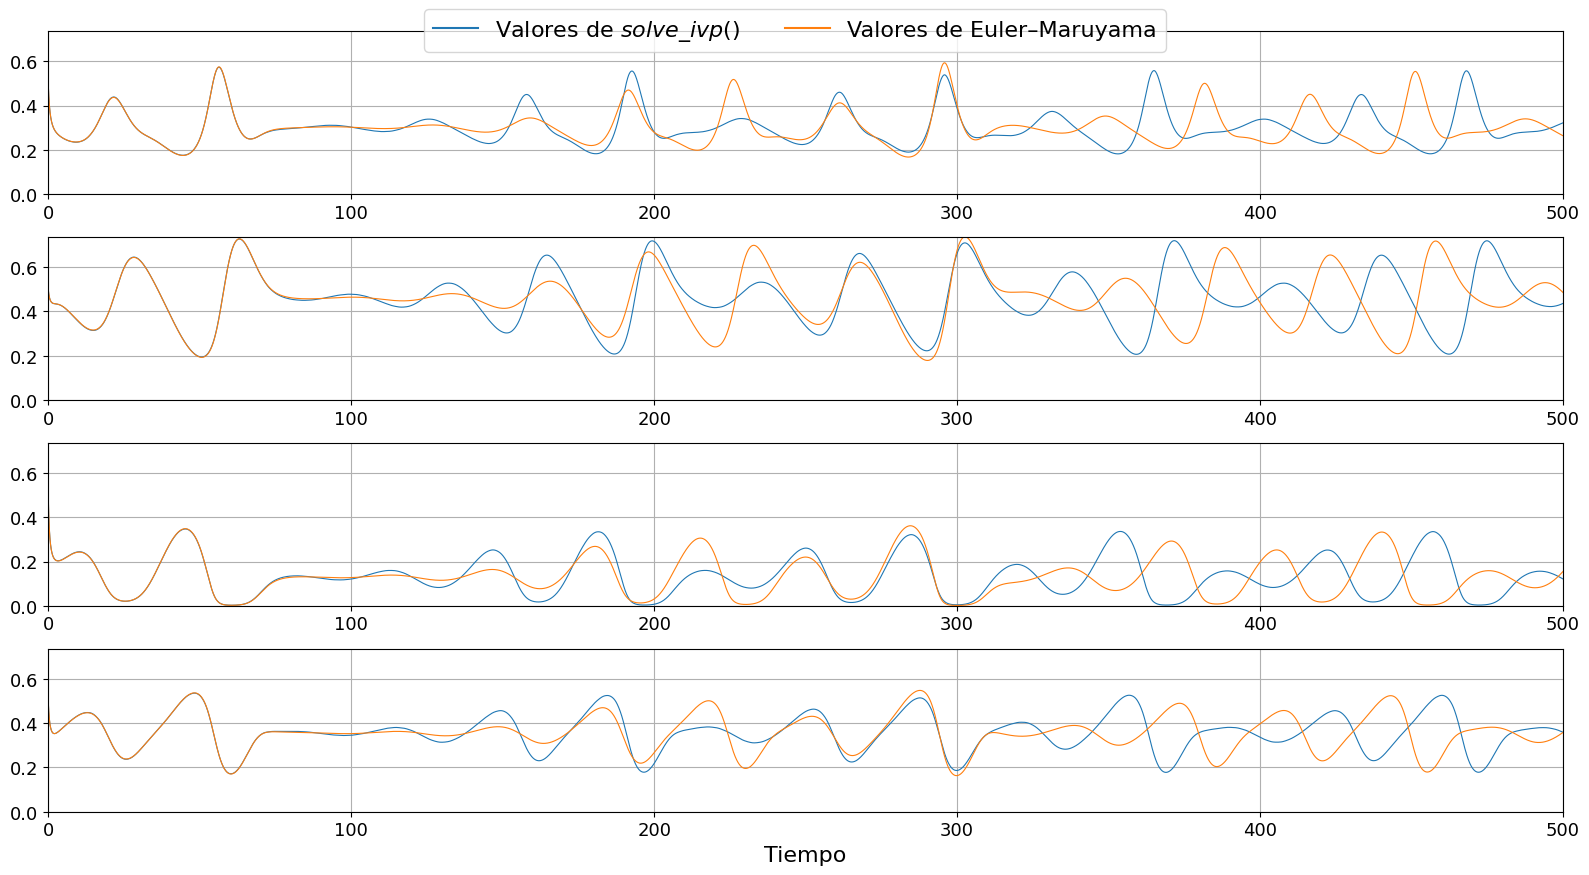

In [96]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(4, 1, figsize=(16, 9))

# Graficamos la solución "sol" (solve_ivp)
ax[0].plot(sol.t, sol.y[0], lw=0.8)
ax[1].plot(sol.t, sol.y[1], lw=0.8)
ax[2].plot(sol.t, sol.y[2], lw=0.8)
ax[3].plot(sol.t, sol.y[3], lw=0.8)

# Graficamos la solución "EM" (Euler–Maruyama)
ax[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 0], lw=0.8)
ax[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 1], lw=0.8)
ax[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 2], lw=0.8)
ax[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 3], lw=0.8)

# Ajustes generales para cada subplot
max_y = max(sol.y.max(), x_vals_EM_4esp.max())
for i in range(4):
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].grid(True)

# Creamos dos "dummy" lines para la leyenda global.
line_solv = mlines.Line2D([], [], color='C0', label=f'Valores de $solve\_ivp()$')
line_em = mlines.Line2D([], [], color='C1', label='Valores de Euler–Maruyama')

# Agregamos la leyenda global en la parte superior central de la figura.
fig.legend(handles=[line_solv, line_em],
           loc='upper center',
           bbox_to_anchor=(0.5, 0.98),
           ncol=2,
           fontsize=16)

ax[3].set_xlabel('Tiempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [97]:
fig.savefig('outputs/comp_trayectorias.png', dpi=600)

### Comparación con y sin ruido
Usamos el mismo método de integración en ambos: Euler-Maruyama

In [94]:
# definimos el sigma
sigma = 0.03 * np.array([1, 1, 1, 1])
# obtenemos la solución sin ruido
t_vals_SR, x_vals_SR = euler_maruyama(system, x0, t_span, dt, r, a, sigma*0)

# obtenemos la solución con ruido pequeño
t_vals_CR, x_vals_CR = euler_maruyama(system, x0, t_span, dt, r, a, sigma)


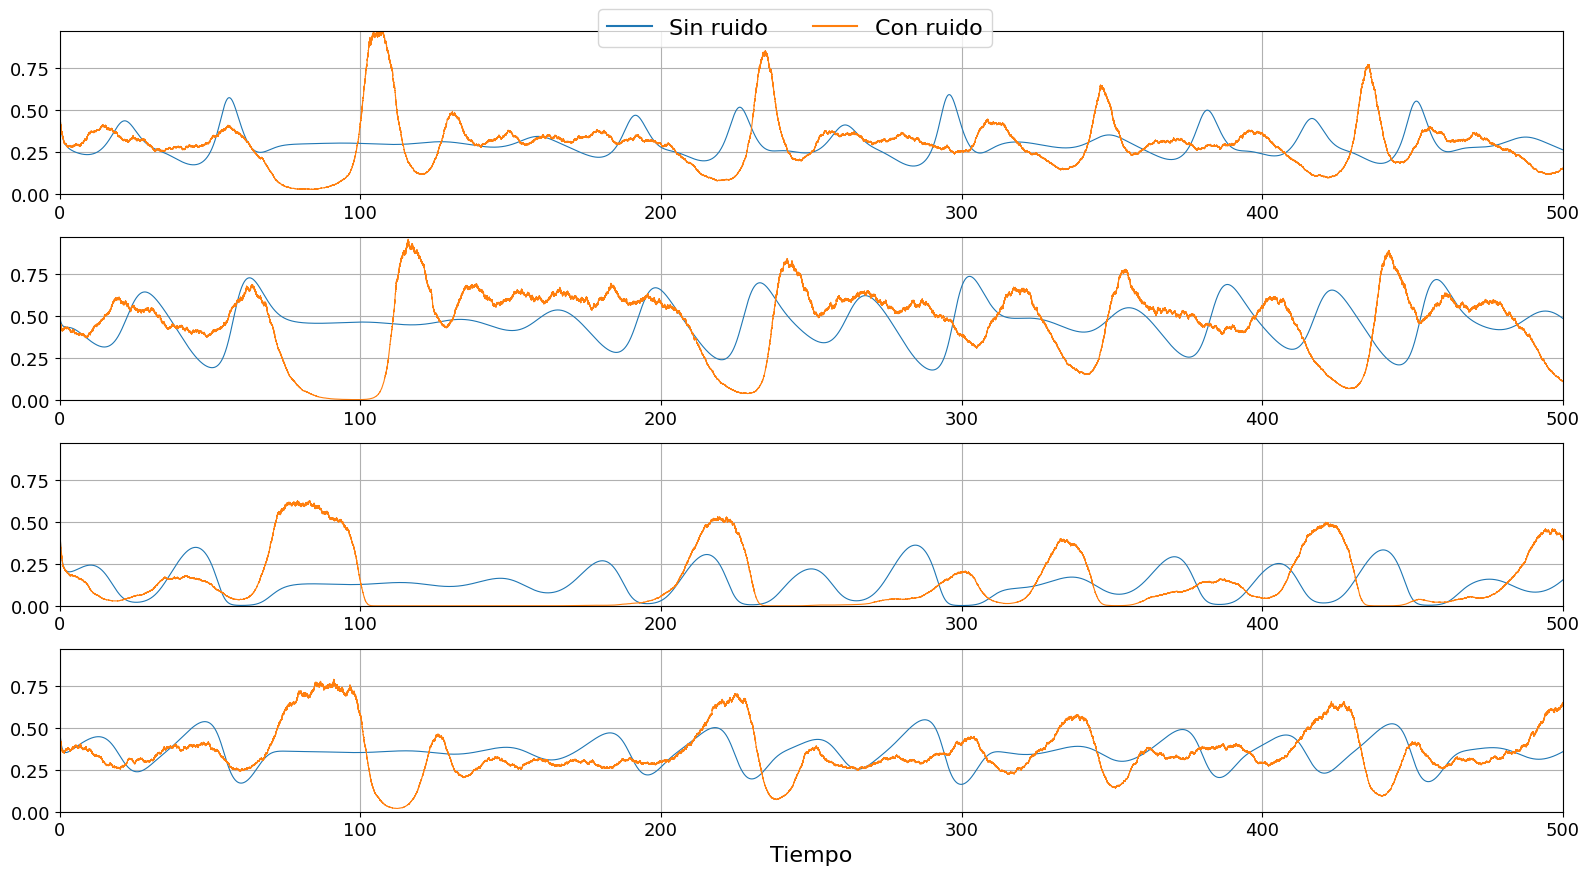

In [95]:
# hacemos la gráfica
import matplotlib.lines as mlines
fig_comp_ruido, ax = plt.subplots(4, 1, figsize=(16, 9))

## graficamos la solución "sol" (solve_ivp)
ax[0].plot(t_vals_SR, x_vals_SR[:, 0], lw=0.8)
ax[1].plot(t_vals_SR, x_vals_SR[:, 1], lw=0.8)
ax[2].plot(t_vals_SR, x_vals_SR[:, 2], lw=0.8)
ax[3].plot(t_vals_SR, x_vals_SR[:, 3], lw=0.8)

# graficamos la solución con ruido
ax[0].plot(t_vals_CR, x_vals_CR[:, 0], lw=0.8)
ax[1].plot(t_vals_CR, x_vals_CR[:, 1], lw=0.8)
ax[2].plot(t_vals_CR, x_vals_CR[:, 2], lw=0.8)
ax[3].plot(t_vals_CR, x_vals_CR[:, 3], lw=0.8)

# Ajustes generales para cada subplot
max_y = max(x_vals_SR.max(), x_vals_CR.max())
for i in range(4):
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].grid(True)

# Creamos dos "dummy" lines para la leyenda global.
line_solv = mlines.Line2D([], [], color='C0', label='Sin ruido')
line_em = mlines.Line2D([], [], color='C1', label='Con ruido')

# Agregamos la leyenda global en la parte superior central de la figura.
fig_comp_ruido.legend(handles=[line_solv, line_em],
           loc='upper center',
           bbox_to_anchor=(0.5, 0.98),
           ncol=2,
           fontsize=16)

ax[3].set_xlabel('Tiempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [99]:
fig_comp_ruido.savefig('outputs/comp_trayectorias_ruido.png', dpi=600)